For each practical exercise (TP), please work in groups of two or three. Then, create a **private GitHub repository** and add me (my GitHub is **arthur-75**) to your project. Finally, share the link to your project (or TP) under  [Practical Exercises](https://docs.google.com/spreadsheets/d/1V-YKgHn71FnwjoFltDhWsPJS7uIuAh9lj6SP2DSCvlY/edit?usp=sharing) and make sure to choose your **team name** :-)

## **1\. Introduction: Why WGAN-GP?**

* **WGAN (Wasserstein GAN)** addresses mode collapse and training instability often encountered in standard GANs. It does this by using the **Wasserstein distance** (also called Earth Mover’s Distance) instead of Jensen-Shannon divergence.  
* **Gradient Penalty (GP)** further stabilizes WGAN training by **forcing the critic** to have gradients with norm **close to 1** for samples **interpolated** between real and fake data.

**Key Concepts**:

1. **Critic** instead of a typical discriminator. It outputs a **real-valued score** (not a probability).  
2. **Wasserstein loss**:

   (We want to **maximize** the real scores and **minimize** the fake scores, effectively maximizing distance between real and fake distributions.)

3. **Gradient Penalty**:

   where x^ are **interpolated samples**. This penalty encourages the critic’s gradient magnitude to be **near 1**.

## **2\. Prepare the Data (CelebA)**

1. **Download** or **unzip** the CelebA dataset.  
2. **Resize** images to a consistent resolution (e.g., 64×64).  
3. **Normalize** pixel values, typically to \[−1,+1\] .


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
#  0. HYPERPARAMETERS
# -----------------------------
IMAGE_SIZE = 64        # Image height/width
CHANNELS = 3           # Using color images
BATCH_SIZE = 1024
Z_DIM = 128            # Dimension of noise (latent space)
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
EPOCHS = 10
CRITIC_STEPS = 5       # Number of critic iterations per generator iteration
GP_WEIGHT = 10.0       # Gradient penalty lambda

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
#  1. DATASET & DATALOADER
# -----------------------------
# This assumes you have a folder "celeba" with images inside subfolders or a single folder.
# If your structure differs, adapt accordingly.

DATA_PATH = "~/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2"  # TODO: Change to your actual path

transform =transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=transform) 
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
#  0. HYPERPARAMETERS
# -----------------------------
IMAGE_SIZE = 64        # Image height/width
CHANNELS = 3           # Using color images
BATCH_SIZE = 128
Z_DIM = 128            # Dimension of noise (latent space)
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
EPOCHS = 10
CRITIC_STEPS = 5       # Number of critic iterations per generator iteration
GP_WEIGHT = 10.0       # Gradient penalty lambda

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
#  1. DATASET & DATALOADER
# -----------------------------
# This assumes you have a folder "celeba" with images inside subfolders or a single folder.
# If your structure differs, adapt accordingly.

DATA_PATH = "~/.cache/kagglehub/datasets/jessicali9530/celeba-dataset/versions/2"  # TODO: Change to your actual path

transform =transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=transform) 
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)


## **3\. Defining the Critic (Similar to a Discriminator)**

1. **Input**: An image of shape (64,64,3)(64,64,3).  
2. **Convolutional layers**: progressively downsample the image.  
3. **Output**: A **single scalar** (score). No Sigmoid—**just a linear output**.

- Why do we remove the **final Sigmoid** in WGAN?  

We removed the final sigmoid to obtain a real values instead of probabilities an dobtain a more accurate result

- How do dropout and stride-based downsampling influence your training stability?

Dropout help to prevent overfitting by randomly desactivated weight. This forces the network to use all of its weight.
Stride-based is used to to reduce the spatial dimension of the features which reduce the memory usage and the computational time

In [3]:
# -----------------------------
#  CRITIC (Similar to Discriminator)
# -----------------------------
class Critic(nn.Module):
    """
    The Critic outputs a SINGLE scalar score for an image.
    No Sigmoid at the end—this is WGAN's difference from typical GANs.
    """
    def __init__(self, channels=3, features_d=64):
        super(Critic, self).__init__()
        # We'll define a series of Conv2d layers with LeakyReLU
        # to downsample from 64x64 to 4x4 (or 1x1 eventually).
        self.model = nn.Sequential(
            # Input: (channels, 64, 64)
            nn.Conv2d(channels, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d, 32, 32)
            nn.Conv2d(features_d, features_d*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d*2, 16, 16)
            nn.Conv2d(features_d*2, features_d*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d*4, 8, 8)
            nn.Conv2d(features_d*4, features_d*8, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_d*8),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_d*8, 4, 4)
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=1, padding=0),
            # Output shape: (1, 1, 1)

            nn.Flatten(start_dim=1)  # shape: (batch_size, 1)
        )

    def forward(self, x):
        return self.model(x)


## **4\. Defining the Generator**

1. **Input**: A **latent vector** z∈R Zdim.  
2. **Use** `Conv2DTranspose` (or transposed convolution) to upsample from zz.  
3. **Output**: A (64,64,3)(64,64,3) image. Typically, end with **tanh** to keep values in \[−1,1\]\[−1,1\].


In [4]:
# -----------------------------
#  3. GENERATOR
# -----------------------------
class Generator(nn.Module):
    """
    The Generator upsamples from a random noise vector z in R^{Z_DIM}
    to generate a (3, 64, 64) image.
    """
    def __init__(self, z_dim=Z_DIM, channels=CHANNELS, features_g=64):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: (z_dim, 1, 1)
            nn.ConvTranspose2d(z_dim, features_g*8, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(features_g*8),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g*8, 4, 4)
            nn.ConvTranspose2d(features_g*8, features_g*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*4),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g*4, 8, 8)
            nn.ConvTranspose2d(features_g*4, features_g*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g*2, 16, 16)
            nn.ConvTranspose2d(features_g*2, features_g, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(features_g),
            nn.LeakyReLU(0.2, inplace=True),

            # (features_g, 32, 32)
            nn.ConvTranspose2d(features_g, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
            # Output shape: (channels, 64, 64)
        )

    def forward(self, x):
        return self.model(x)



INITIALIZE MODELS &  OPTIMIZERS :

In [5]:
# -----------------------------
#  4. INITIALIZE MODELS
# -----------------------------
critic = Critic(channels=CHANNELS, features_d=64).to(DEVICE)
generator = Generator(z_dim=Z_DIM, channels=CHANNELS, features_g=64).to(DEVICE)

# -----------------------------
#  5. OPTIMIZERS
# -----------------------------
# WGAN-GP often uses Adam with betas=(0.5, 0.999) or a small tweak
critic_optimizer = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
generator_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))



## **6\. Gradient Penalty (GP)**

1. Randomly sample **α** in \[0,1\].  
2. **Interpolate** real & fake:

   ![][image1]  
3. Compute ∇x^critic(x^).  
4. Compute ∥⋅∥ (the L2 norm) and **penalize** deviations from 1\.

- Why does WGAN-GP require **interpolating** between real and fake samples?  
- What if the gradient norm is exactly zero or extremely large?


In [6]:
# -----------------------------
#  6. HELPER FUNCTION: Gradient Penalty
# -----------------------------
def gradient_penalty(critic, real, fake, device="cpu"):
    """
    Compute the gradient penalty for WGAN-GP.
    1. Randomly interpolate between real and fake.
    2. Calculate gradient of Critic’s output w.r.t. this interpolated data.
    3. Penalize deviations of gradient norm from 1.
    """
    batch_size, c, h, w = real.shape
    alpha = torch.rand((batch_size, 1, 1, 1), device=device).repeat(1, c, h, w)

    # Create interpolated images
    interpolated = real * alpha + fake * (1 - alpha)
    interpolated.requires_grad_(True)

    # Critic score on interpolated images
    mixed_scores = critic(interpolated)

    # Take gradient of scores w.r.t. interpolated images
    gradient = torch.autograd.grad(
        inputs=interpolated,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]  # tuple of length 1

    # Flatten gradients: shape => (batch_size, all pixels)
    gradient = gradient.view(gradient.size(0), -1)
    # L2 norm
    gradient_norm = gradient.norm(2, dim=1)
    # GP = E[(||gradient||2 - 1)^2]
    gp = torch.mean((gradient_norm - 1) ** 2)
    return gp

## **7\. Compile and Train**

1. **Optimizers**: Typically **Adam** with a small learning rate (like 2×10^−4).  
2. **Loss**:  
   * Critic: E\[fake\] − E\[real\] \+ GP.   
   * Generator: −E\[fake\] − E\[fake\].  
3. **Callbacks**:  
   * Save **checkpoints** for your model.  
   * Periodically **generate** images to monitor progress.

**Things to watch**:

* If the critic or generator losses become **NaN**, check your gradient penalty or learning rate.  
* You might want to **clip** the gradients or use smaller batch sizes if memory is limited.


In [7]:
from tqdm import tqdm

print("Starting Training...")
g_losses = []
c_losses = []

for epoch in range(EPOCHS):
    # Create a progress bar for this epoch
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch_idx, (real_images, _) in progress_bar:
        real_images = real_images.to(DEVICE)
        cur_batch_size = real_images.shape[0]

        # -----------------------------
        # (a) Train Critic multiple times
        # -----------------------------
        for _ in range(CRITIC_STEPS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1, device=DEVICE)
            fake_images = generator(noise)

            critic_optimizer.zero_grad()

            # Critic scores
            critic_real = critic(real_images).view(-1)
            critic_fake = critic(fake_images).view(-1)

            # Wasserstein distance
            wass_distance = torch.mean(critic_fake) - torch.mean(critic_real)

            # Gradient penalty
            gp = gradient_penalty(critic, real_images, fake_images, device=DEVICE)

            # Critic total loss
            critic_loss = wass_distance + GP_WEIGHT * gp
            critic_loss.backward(retain_graph=True)
            critic_optimizer.step()

        # -----------------------------
        # (b) Train Generator
        # -----------------------------
        generator_optimizer.zero_grad()
        critic_fake_for_g = critic(fake_images).view(-1)  # Reuse fake_images from last loop
        gen_loss = -torch.mean(critic_fake_for_g)
        gen_loss.backward()
        generator_optimizer.step()

        # Save losses
        c_losses.append(critic_loss.item())
        g_losses.append(gen_loss.item())

        # Update the tqdm progress bar with the latest losses
        progress_bar.set_postfix({
            "Critic Loss": f"{critic_loss.item():.4f}",
            "GP": f"{gp.item():.4f}",
            "WassDist": f"{wass_distance.item():.4f}",
            "Gen Loss": f"{gen_loss.item():.4f}",
        })



Starting Training...


Epoch 10/10: 100%|██████████| 1583/1583 [09:28<00:00,  2.78it/s, Critic Loss=-1.8358, GP=0.0068, WassDist=-1.9034, Gen Loss=88.4767]   


If dose work then you can use a pre-trained model:

In [12]:
GEN_PATH = "tp2-2_gan_gp_generator.pth"
CRITIC_PATH = "tp2-2_gan_gp_discriminator.pth"

# Load state dictionaries
generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
critic.load_state_dict(torch.load(CRITIC_PATH, map_location=DEVICE))
generator.eval()
critic.eval()

/tmp/ipykernel_60133/3791206488.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(GEN_PATH, map_location=DEVICE))
/tmp/ipykernel_60133

Critic(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Flatten(start_dim=1, end_dim=-1)
  )
)

## **8\. Plot losses**

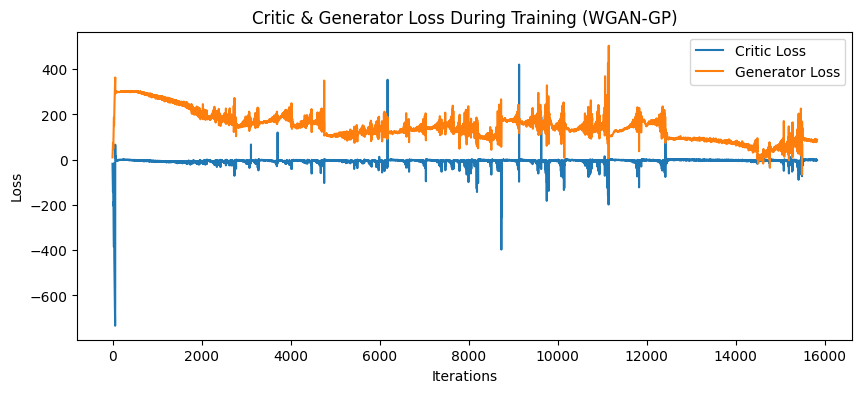

In [13]:
# -----------------------------
#  8. PLOTTING LOSSES
# -----------------------------
plt.figure(figsize=(10,4))
plt.title("Critic & Generator Loss During Training (WGAN-GP)")
plt.plot(c_losses, label="Critic Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


- What do you observe ? 

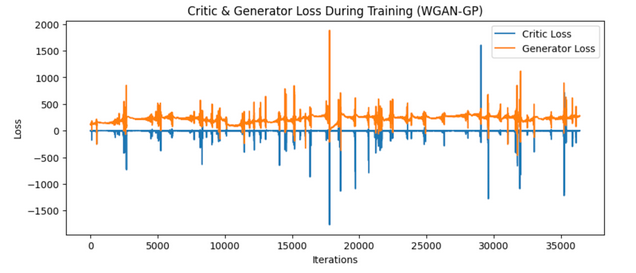

## **9\. Generate Images & Evaluate**

1. Sample **random vectors** z.  
2. Pass them through the generator: Xgen \= G(z)  
3. **Visualize** or **save** them to see how well the model is learning to produce faces.

**Follow-up (optional)**:

* Try **changing** `Z_DIM` or **adding** more convolutional layers.  
* Evaluate **Fréchet Inception Distance (FID)** or **Inception Score** for a more objective measure of face quality.


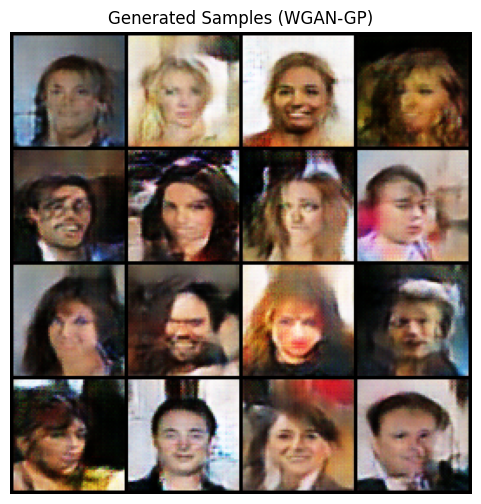

In [14]:
# -----------------------------
#  9. GENERATE AND DISPLAY SAMPLES
# -----------------------------
def show_generated_samples(generator, num_samples=16, z_dim=Z_DIM):
    """
    Generate 'num_samples' images from the generator and display them in a grid.
    """
    generator.eval()
    noise = torch.randn(num_samples, z_dim, 1, 1).to(DEVICE)
    with torch.no_grad():
        fake = generator(noise)
    fake = fake.cpu() * 0.5 + 0.5  # Denormalize from [-1,1] to [0,1]

    grid_img = torchvision.utils.make_grid(fake, nrow=4)
    plt.figure(figsize=(6,6))
    plt.imshow(grid_img.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title("Generated Samples (WGAN-GP)")
    plt.show()
    generator.train()

show_generated_samples(generator, num_samples=16)